In [1]:
from google.colab import files
uploaded = files.upload()


Saving archive.zip to archive.zip


In [7]:
import zipfile
with zipfile.ZipFile("archive.zip", 'r') as zip_ref:
    zip_ref.extractall("data")


In [8]:
import os
os.listdir("data")


['corrected.gz',
 'kddcup.data.corrected',
 'kddcup.newtestdata_10_percent_unlabeled',
 'typo-correction.txt',
 'kddcup.data_10_percent_corrected',
 'kddcup.data_10_percent',
 'corrected',
 'kddcup.testdata.unlabeled_10_percent.gz',
 'kddcup.testdata.unlabeled',
 'kddcup.testdata.unlabeled.gz',
 'training_attack_types',
 'kddcup.names',
 'kddcup.data_10_percent.gz',
 'kddcup.testdata.unlabeled_10_percent',
 'kddcup.data.gz',
 'kddcup.data',
 'kddcup.newtestdata_10_percent_unlabeled.gz']

In [10]:
import pandas as pd

df = pd.read_csv("data/kddcup.data.corrected", header=None)


In [11]:
import pandas as pd


df = pd.read_csv('data/kddcup.data.corrected', header=None)


columns = [
    "duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment",
    "urgent","hot","num_failed_logins","logged_in","num_compromised","root_shell","su_attempted",
    "num_root","num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate",
    "rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate",
    "dst_host_count","dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate",
    "dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate","label"
]
df.columns = columns


df['is_attack'] = df['label'].apply(lambda x: 0 if x == 'normal.' else 1)


In [13]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

X = df.drop(['label', 'is_attack'], axis=1)
cat_cols = X.select_dtypes(include='object').columns

for col in cat_cols:
    X[col] = LabelEncoder().fit_transform(X[col])

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


print("Shape of preprocessed feature matrix (X_scaled):", X_scaled.shape)


print("\nFirst 5 rows of scaled features:")
print(X_scaled[:5])


print("\nMin value (should be 0.0):", X_scaled.min())
print("Max value (should be 1.0):", X_scaled.max())



Shape of preprocessed feature matrix (X_scaled): (4898431, 41)

First 5 rows of scaled features:
[[0.00000000e+00 5.00000000e-01 3.47826087e-01 9.00000000e-01
  1.55801178e-07 3.44108046e-05 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.95694716e-03 1.95694716e-03
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 5.00000000e-01 3.47826087e-01 9.00000000e-01
  1.17394376e-07 3.45665373e-06 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 

In [14]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report

iso_model = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
iso_model.fit(X_scaled)
df['iso_anomaly'] = iso_model.predict(X_scaled)
df['iso_anomaly'] = df['iso_anomaly'].map({1: 0, -1: 1})


In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_dim = X_scaled.shape[1]
encoding_dim = 20

input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation='relu')(input_layer)
decoded = layers.Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = models.Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')


history = autoencoder.fit(X_scaled, X_scaled,
                          epochs=50,
                          batch_size=256,
                          shuffle=True,
                          validation_split=0.2)



Epoch 1/50
15308/15308 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - loss: 0.0089 - val_loss: 5.1587e-04
Epoch 2/50
15308/15308 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - loss: 8.0822e-05 - val_loss: 7.2323e-04
Epoch 3/50
15308/15308 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - loss: 5.8446e-05 - val_loss: 0.0015
Epoch 4/50
15308/15308 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - loss: 5.3277e-05 - val_loss: 0.0015
Epoch 5/50
15308/15308 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 4.8898e-05 - val_loss: 0.0019
Epoch 6/50
15308/15308 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step - loss: 4.6450e-05 - val_loss: 0.0025
Epoch 7/50
15308/15308 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - loss: 4.5334e-05 - val_loss: 0.0030
Epoch 8/50
15308/15308 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - loss: 4.2699e-05 - val_loss: 0.0032
Epoch 9/50
15308/15308 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 4.1481e-05 - val_loss: 0.0034
Epoch 10/50
15308/15308 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 4.0577e-05 - val_loss: 0.0034
Epoch 11/50
15308/15308 ━━━━━━━━━━━━━━━━━━━━ 

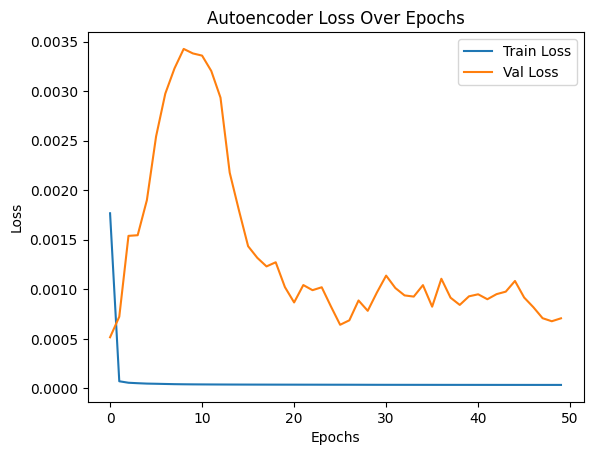

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Autoencoder Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam


In [8]:
!unzip archive.zip


Archive:  archive.zip
  inflating: corrected.gz            
  inflating: corrected/corrected     
  inflating: kddcup.data.corrected   
  inflating: kddcup.data.gz          
  inflating: kddcup.data/kddcup.data  
  inflating: kddcup.data_10_percent.gz  
  inflating: kddcup.data_10_percent/kddcup.data_10_percent  
  inflating: kddcup.data_10_percent_corrected  
  inflating: kddcup.names            
  inflating: kddcup.newtestdata_10_percent_unlabeled.gz  
  inflating: kddcup.newtestdata_10_percent_unlabeled/kddcup.newtestdata_10_percent_unlabeled  
  inflating: kddcup.testdata.unlabeled.gz  
  inflating: kddcup.testdata.unlabeled/kddcup.testdata.unlabeled  
  inflating: kddcup.testdata.unlabeled_10_percent.gz  
  inflating: kddcup.testdata.unlabeled_10_percent/kddcup.testdata.unlabeled_10_percent  
  inflating: training_attack_types   
  inflating: typo-correction.txt     


In [9]:
!ls


archive.zip			  kddcup.names
corrected			  kddcup.newtestdata_10_percent_unlabeled
corrected.gz			  kddcup.newtestdata_10_percent_unlabeled.gz
data				  kddcup.testdata.unlabeled
kddcup.data			  kddcup.testdata.unlabeled_10_percent
kddcup.data_10_percent		  kddcup.testdata.unlabeled_10_percent.gz
kddcup.data_10_percent_corrected  kddcup.testdata.unlabeled.gz
kddcup.data_10_percent.gz	  sample_data
kddcup.data.corrected		  training_attack_types
kddcup.data.gz			  typo-correction.txt


In [10]:
import pandas as pd

df = pd.read_csv("kddcup.data_10_percent_corrected", header=None)


In [11]:
import pandas as pd
columns = ['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent',
    'hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root',
    'num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login',
    'count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate',
    'diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate',
    'dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
    'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','label']
df = pd.read_csv('kddcup.data_10_percent_corrected', names=columns)
df['is_attack'] = df['label'].apply(lambda x: 0 if x == 'normal.' else 1)
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
X = df.drop(['label', 'is_attack'], axis=1)
cat_cols = X.select_dtypes(include='object').columns
for col in cat_cols:
    X[col] = LabelEncoder().fit_transform(X[col])
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
from sklearn.ensemble import IsolationForest
iso = IsolationForest(contamination=0.1, random_state=42)
df['iso_anomaly'] = iso.fit_predict(X_scaled)
df['iso_anomaly'] = df['iso_anomaly'].map({1: 0, -1: 1})
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.metrics import classification_report
input_dim = X_scaled.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation='relu')(input_layer)
encoded = Dense(8, activation='relu')(encoded)
decoded = Dense(16, activation='relu')(encoded)
output_layer = Dense(input_dim, activation='sigmoid')(decoded)
autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_scaled, X_scaled, epochs=5, batch_size=256, shuffle=True, validation_split=0.1, verbose=1)
reconstructions = autoencoder.predict(X_scaled)
mse = tf.keras.losses.mse(X_scaled, reconstructions).numpy()
threshold = mse.mean() + mse.std()
df['ae_anomaly'] = (mse > threshold).astype(int)
from sklearn.metrics import classification_report
print("🔍 Isolation Forest Results:")
print(classification_report(df['is_attack'], df['iso_anomaly']))
print("\n🔍 Autoencoder Results:")
print(classification_report(df['is_attack'], df['ae_anomaly']))


Epoch 1/5
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0449 - val_loss: 0.0166
Epoch 2/5
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0015 - val_loss: 0.0135
Epoch 3/5
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0011 - val_loss: 0.0117
Epoch 4/5
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 9.1810e-04 - val_loss: 0.0121
Epoch 5/5
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 8.1932e-04 - val_loss: 0.0094
15439/15439 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step
🔍 Isolation Forest Results:
              precision    recall  f1-score   support

           0       0.18      0.80      0.29     97278
           1       0.61      0.08      0.14    396743

    accuracy                           0.22    494021
   macro avg       0.39      0.44      0.21    494021
weighted avg       0.52      0.22      0.17    494021


🔍 Autoencoder Results:
              precision    recall  f1-score   support

           0       0.19      0.90      0.31     97278
           1       0.71

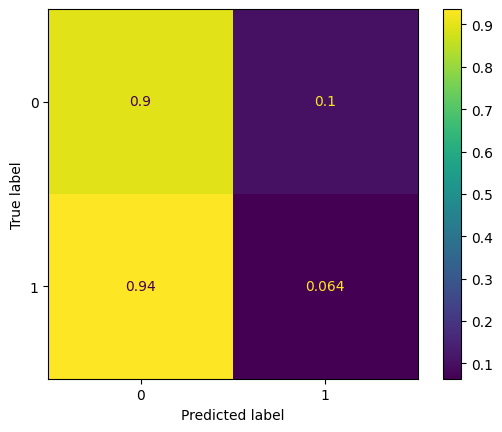

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(df['is_attack'], df['ae_anomaly'], normalize='true')


In [13]:
from sklearn.metrics import roc_auc_score
print("Isolation Forest AUC:", roc_auc_score(df['is_attack'], df['iso_anomaly']))
print("Autoencoder AUC:", roc_auc_score(df['is_attack'], df['ae_anomaly']))


Isolation Forest AUC: 0.43901137415494984
Autoencoder AUC: 0.4798411705742015


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


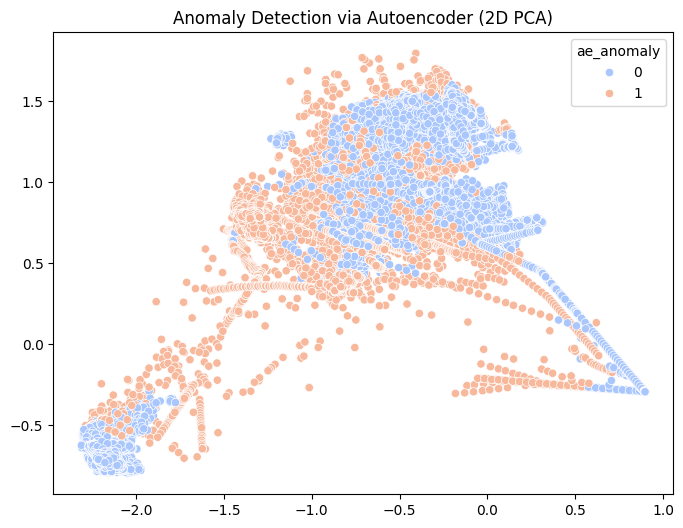

In [14]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_2d[:,0], y=X_2d[:,1], hue=df['ae_anomaly'], palette='coolwarm')
plt.title('Anomaly Detection via Autoencoder (2D PCA)')
plt.show()


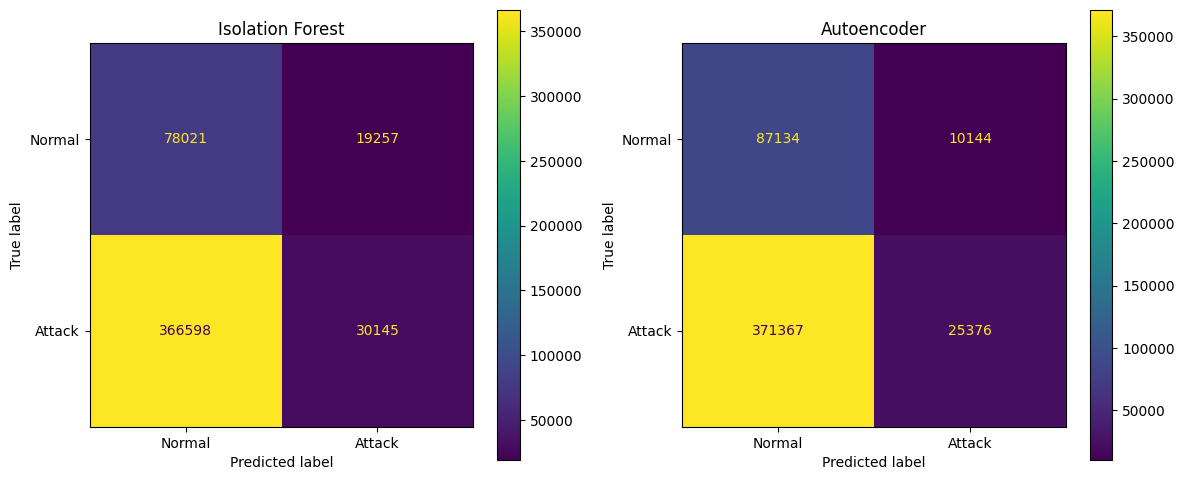

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

cm_if = confusion_matrix(df['is_attack'], df['iso_anomaly'])
cm_ae = confusion_matrix(df['is_attack'], df['ae_anomaly'])

ConfusionMatrixDisplay(cm_if, display_labels=["Normal", "Attack"]).plot(ax=ax[0], values_format='d')
ax[0].set_title("Isolation Forest")

ConfusionMatrixDisplay(cm_ae, display_labels=["Normal", "Attack"]).plot(ax=ax[1], values_format='d')
ax[1].set_title("Autoencoder")

plt.tight_layout()
plt.show()


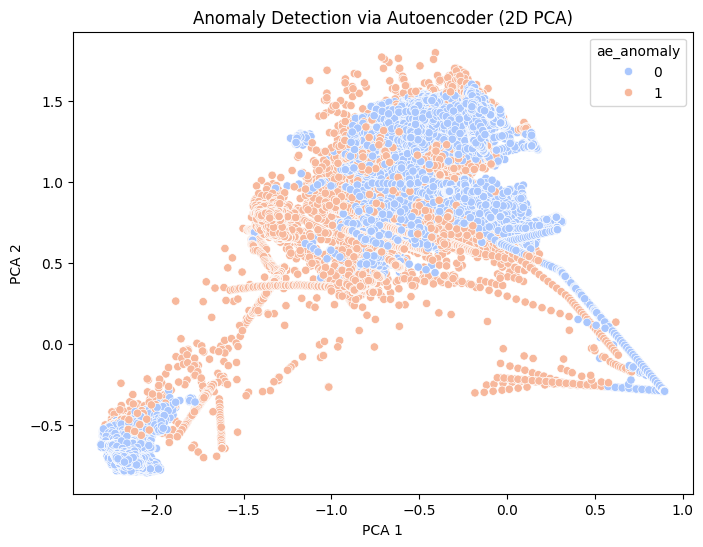

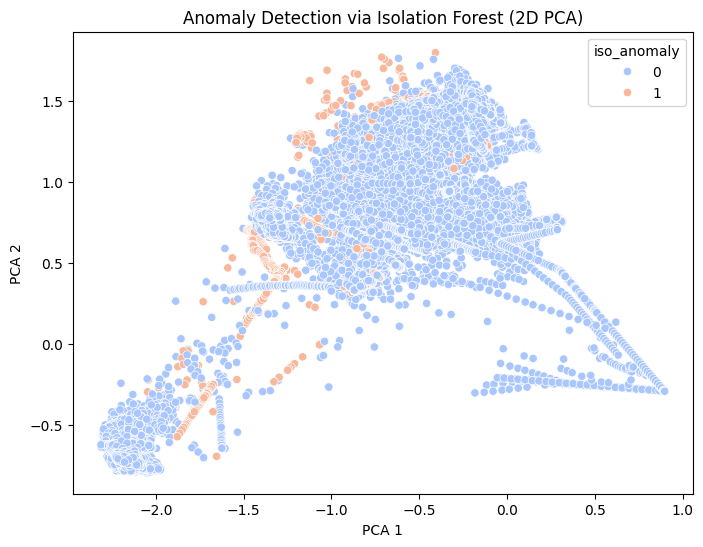

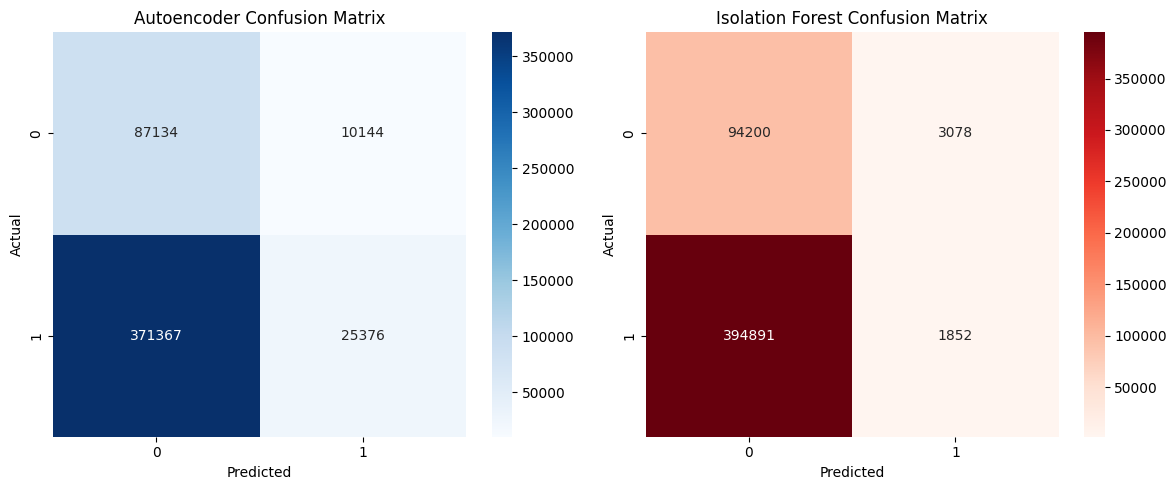

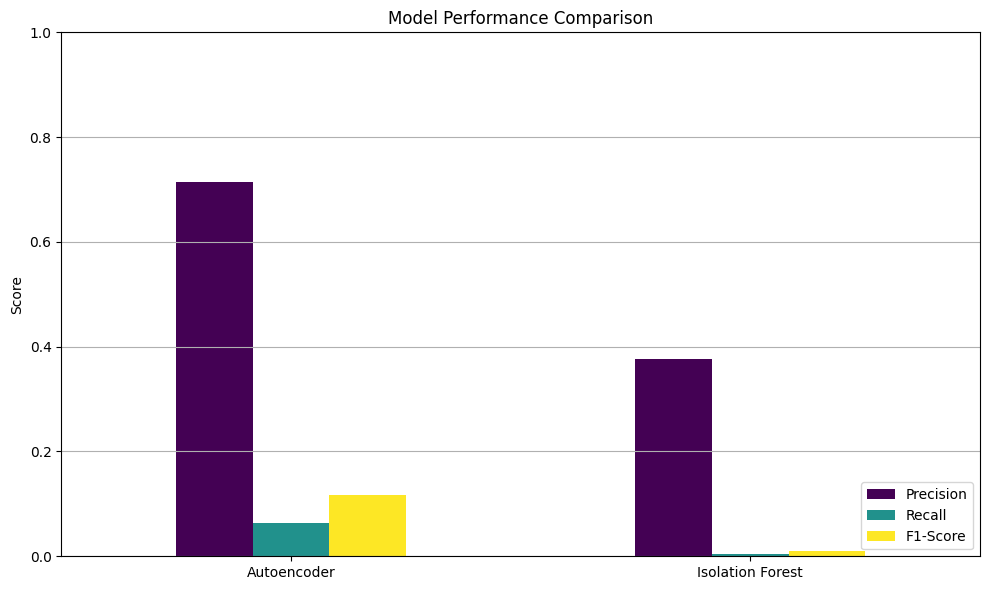

In [19]:
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)


iso_forest = IsolationForest(contamination=0.01, random_state=42)
df['iso_score'] = iso_forest.fit(X_scaled).decision_function(X_scaled)
df['iso_anomaly'] = iso_forest.predict(X_scaled)
df['iso_anomaly'] = df['iso_anomaly'].map({1: 0, -1: 1})


plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=df['ae_anomaly'], palette='coolwarm')
plt.title('Anomaly Detection via Autoencoder (2D PCA)')
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=df['iso_anomaly'], palette='coolwarm')
plt.title('Anomaly Detection via Isolation Forest (2D PCA)')
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


cm_ae = confusion_matrix(df['is_attack'], df['ae_anomaly'])
cm_iso = confusion_matrix(df['is_attack'], df['iso_anomaly'])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_ae, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Autoencoder Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(cm_iso, annot=True, fmt='d', cmap='Reds', ax=axes[1])
axes[1].set_title("Isolation Forest Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()


metrics = {
    'Autoencoder': {
        'Precision': precision_score(df['is_attack'], df['ae_anomaly']),
        'Recall': recall_score(df['is_attack'], df['ae_anomaly']),
        'F1-Score': f1_score(df['is_attack'], df['ae_anomaly'])
    },
    'Isolation Forest': {
        'Precision': precision_score(df['is_attack'], df['iso_anomaly']),
        'Recall': recall_score(df['is_attack'], df['iso_anomaly']),
        'F1-Score': f1_score(df['is_attack'], df['iso_anomaly'])
    }
}


metrics_df = pd.DataFrame(metrics).T


metrics_df.plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [15]:
df['pca1'] = X_2d[:, 0]
df['pca2'] = X_2d[:, 1]
df.to_csv("anomaly_detection_results.csv", index=False)
